In [3]:
#!pip install scikeras

In [4]:
import numpy as np
import datetime
import pandas as pd
import warnings
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
import time
import gc
import datetime
#from google.colab import drive
#drive.mount('/content/drive')

pd.set_option('display.float_format', lambda x: '%.3f' %x)
warnings.filterwarnings("ignore")

In [5]:
##### Memory reduction script 1

def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

##### Memory reduction script 2

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)

        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')

        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

##### Memory reduction script 3
# https://www.kaggle.com/kyakovlev/ieee-data-minification
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

##### Functions
# 1st function: to graph time series based on TransactionDT vs the variable selected

def scatter(column):
    fr,no_fr = (train[train['isFraud'] == 1], train[train['isFraud'] == 0])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    ax1.title.set_text('Histogram ' + column + ' when isFraud == 0')
    ax1.set_ylim(train[column].min() - 1,train[column].max() + 1)
    ax1.scatter(x = no_fr['TransactionDT'], y = no_fr[column], color = 'blue', marker='o')
    ax2.title.set_text('Histogram ' + column + ' when isFraud == 1')
    ax2.set_ylim(train[column].min() - 1,train[column].max() + 1)
    ax2.scatter(x = fr['TransactionDT'], y = fr[column], color = 'red', marker='o')
    plt.show()

# 2nd function: to show a ranking of pearson correlation with the variable selected

def corr(data,column):
    print('Correlation with ' + column)
    print(train[data].corrwith(data[column]).abs().sort_values(ascending = False)[1:])

# 3rd function: to reduce the groups based on Nans agroupation and pearson correlation

def reduce(groups):
    result = list()
    for values in groups:
        maxval = 0
        val = values[0]
        for value in values:
            unique_values = data[value].nunique()
            if unique_values > maxval:
                maxval = unique_values
                val = value
        result.append(value)
    return result

# 4th function: to sort each column in ascending order based on its number

def order_finalcolumns(final_Xcolumns):
    return sorted(final_Xcolumns, key=lambda x: int("".join([i for i in x if i.isdigit()])))


In [6]:
#Carregando os dados
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

#Efetuar o merge pela coluna TransactionID
data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')


In [7]:
%%time
#Tratamento para melhorar a coluna DeviceInfo
data.loc[data['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
data.loc[data['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
data.loc[data['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
data.loc[data['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
data.loc[data['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
data.loc[data['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
data.loc[data['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
data.loc[data['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
data.loc[data['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
data.loc[data['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
data.loc[data['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
data.loc[data['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
data.loc[data['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
data.loc[data['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
data.loc[data['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
data.loc[data['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
data.loc[data['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'
#Tratamento para unificar e-mail por provider.
data.loc[data['P_emaildomain'].str.contains('gmail', na=False), 'P_emaildomain'] = 'Google'
data.loc[data['P_emaildomain'].str.contains('hotmail|outlook|msn|live|', na=False), 'P_emaildomain'] = 'Microsoft'
data.loc[data['P_emaildomain'].str.contains('yahoo|ymail|att|bellsouth', na=False), 'P_emaildomain'] = 'Yahoo'
data.loc[data['P_emaildomain'].str.contains('icloud|me|mac', na=False), 'P_emaildomain'] = 'Apple'
data.loc[data['P_emaildomain'].str.contains('aol|aim', na=False), 'P_emaildomain'] = 'AOL'
data.loc[data['P_emaildomain'].str.contains('embarqmail|centurylink', na=False), 'P_emaildomain'] = 'CenturyLink'
data.loc[data['P_emaildomain'].str.contains('frontier', na=False), 'P_emaildomain'] = 'Frontier'
data.loc[data['P_emaildomain'].str.contains('netzero', na=False), 'P_emaildomain'] = 'Netzero'
data.loc[data['P_emaildomain'].str.contains('cfl|sc.rr|twc', na=False), 'P_emaildomain'] = 'Spectrum'
data.loc[data['P_emaildomain'].str.contains('protonmail|ptd|servicios|roadrunner|juno|windstream|scranton', na=False), 'P_emaildomain'] = 'Others'
data.loc[data['P_emaildomain'].str.contains('q.com|web|suddenlink|cableone|prodigy|gmx', na=False), 'P_emaildomain'] = 'Others'

data.loc[data['R_emaildomain'].str.contains('gmail', na=False), 'R_emaildomain'] = 'Google'
data.loc[data['R_emaildomain'].str.contains('hotmail|outlook|msn|live|', na=False), 'R_emaildomain'] = 'Microsoft'
data.loc[data['R_emaildomain'].str.contains('yahoo|ymail|att|bellsouth', na=False), 'R_emaildomain'] = 'Yahoo'
data.loc[data['R_emaildomain'].str.contains('icloud|me|mac', na=False), 'R_emaildomain'] = 'Apple'
data.loc[data['R_emaildomain'].str.contains('aol|aim', na=False), 'R_emaildomain'] = 'AOL'
data.loc[data['R_emaildomain'].str.contains('embarqmail|centurylink', na=False), 'R_emaildomain'] = 'CenturyLink'
data.loc[data['R_emaildomain'].str.contains('frontier', na=False), 'R_emaildomain'] = 'Frontier'
data.loc[data['R_emaildomain'].str.contains('netzero', na=False), 'R_emaildomain'] = 'Netzero'
data.loc[data['R_emaildomain'].str.contains('cfl|sc.rr|twc', na=False), 'R_emaildomain'] = 'Spectrum'
data.loc[data['R_emaildomain'].str.contains('protonmail|ptd|servicios|roadrunner|juno|windstream|scranton', na=False), 'R_emaildomain'] = 'Others'
data.loc[data['R_emaildomain'].str.contains('q.com|web|suddenlink|cableone|prodigy|gmx', na=False), 'R_emaildomain'] = 'Others'

#Temos o TransactionDT que é uma data aleatorio no tempo, irei transformar em Dia,Mes e Ano para facilitar a analise.
#data['TransactionDT'] = pd.to_datetime(data['TransactionDT']) - Não ficou bom.

# Converter a coluna de datas para componentes numéricos
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
data['TransactionDT'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
data.insert(4, 'TransHour', data['TransactionDT'].dt.hour)
data.insert(5, 'TransDay', data['TransactionDT'].dt.day)
data.insert(6, 'TransMonth', data['TransactionDT'].dt.month)
data.insert(7, 'TransWeek', data['TransactionDT'].dt.isocalendar().week)
data = data.drop(columns=['TransactionDT'])

CPU times: user 2.97 s, sys: 114 ms, total: 3.08 s
Wall time: 3.08 s


In [8]:
#data = data.replace(np.nan, 0)
#Efetuo redução de memoria.
data = reduce_mem_usage_sd(data, verbose=True)

Column TransactionID: int64 -> int32, na_count=0, n_uniq=590540
Column isFraud: int64 -> int8, na_count=0, n_uniq=2
Column TransactionAmt: float64 -> float32, na_count=0, n_uniq=20902
Column TransHour: int32 -> int8, na_count=0, n_uniq=24
Column TransDay: int32 -> int8, na_count=0, n_uniq=31
Column TransMonth: int32 -> int8, na_count=0, n_uniq=7
Column TransWeek: UInt32 -> UInt32, na_count=0, n_uniq=27
Column ProductCD: object -> object, na_count=0, n_uniq=5
Column card1: int64 -> int16, na_count=0, n_uniq=13553
Column card2: float64 -> float16, na_count=8933, n_uniq=501
Column card3: float64 -> float16, na_count=1565, n_uniq=115
Column card4: object -> object, na_count=1577, n_uniq=5
Column card5: float64 -> float16, na_count=4259, n_uniq=120
Column card6: object -> object, na_count=1571, n_uniq=5
Column addr1: float64 -> float16, na_count=65706, n_uniq=333
Column addr2: float64 -> float16, na_count=65706, n_uniq=75
Column dist1: float64 -> float32, na_count=352271, n_uniq=2652
Column

Column V224: float64 -> float16, na_count=460110, n_uniq=80
Column V225: float64 -> float16, na_count=460110, n_uniq=36
Column V226: float64 -> float16, na_count=460110, n_uniq=82
Column V227: float64 -> float16, na_count=449124, n_uniq=51
Column V228: float64 -> float16, na_count=460110, n_uniq=56
Column V229: float64 -> float16, na_count=460110, n_uniq=92
Column V230: float64 -> float16, na_count=460110, n_uniq=67
Column V231: float64 -> float16, na_count=460110, n_uniq=295
Column V232: float64 -> float16, na_count=460110, n_uniq=339
Column V233: float64 -> float16, na_count=460110, n_uniq=334
Column V234: float64 -> float16, na_count=449124, n_uniq=123
Column V235: float64 -> float16, na_count=460110, n_uniq=25
Column V236: float64 -> float16, na_count=460110, n_uniq=47
Column V237: float64 -> float16, na_count=460110, n_uniq=41
Column V238: float64 -> float16, na_count=449124, n_uniq=25
Column V239: float64 -> float16, na_count=449124, n_uniq=25
Column V240: float64 -> float16, na_

Column id_24: float64 -> float16, na_count=585793, n_uniq=13
Column id_25: float64 -> float16, na_count=585408, n_uniq=342
Column id_26: float64 -> float16, na_count=585377, n_uniq=96
Column id_27: object -> object, na_count=585371, n_uniq=3
Column id_28: object -> object, na_count=449562, n_uniq=3
Column id_29: object -> object, na_count=449562, n_uniq=3
Column id_30: object -> object, na_count=512975, n_uniq=76
Column id_31: object -> object, na_count=450258, n_uniq=131
Column id_32: float64 -> float16, na_count=512954, n_uniq=5
Column id_33: object -> object, na_count=517251, n_uniq=261
Column id_34: object -> object, na_count=512735, n_uniq=5
Column id_35: object -> object, na_count=449555, n_uniq=3
Column id_36: object -> object, na_count=449555, n_uniq=3
Column id_37: object -> object, na_count=449555, n_uniq=3
Column id_38: object -> object, na_count=449555, n_uniq=3
Column DeviceType: object -> object, na_count=449730, n_uniq=3
Column DeviceInfo: object -> object, na_count=4718

In [9]:
columns= list(data.columns[:20])
columns

['TransactionID',
 'isFraud',
 'TransactionAmt',
 'TransHour',
 'TransDay',
 'TransMonth',
 'TransWeek',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain']

In [10]:
for col in columns:
    print(f'{col} NaNs: {data[col].isna().sum()} | {data[col].isna().sum()/data.shape[0]:.2%}')

TransactionID NaNs: 0 | 0.00%
isFraud NaNs: 0 | 0.00%
TransactionAmt NaNs: 0 | 0.00%
TransHour NaNs: 0 | 0.00%
TransDay NaNs: 0 | 0.00%
TransMonth NaNs: 0 | 0.00%
TransWeek NaNs: 0 | 0.00%
ProductCD NaNs: 0 | 0.00%
card1 NaNs: 0 | 0.00%
card2 NaNs: 8933 | 1.51%
card3 NaNs: 1565 | 0.27%
card4 NaNs: 1577 | 0.27%
card5 NaNs: 4259 | 0.72%
card6 NaNs: 1571 | 0.27%
addr1 NaNs: 65706 | 11.13%
addr2 NaNs: 65706 | 11.13%
dist1 NaNs: 352271 | 59.65%
dist2 NaNs: 552913 | 93.63%
P_emaildomain NaNs: 94456 | 15.99%
R_emaildomain NaNs: 453249 | 76.75%


In [11]:
# If we look closely to % NaNs data, most of them have low number of missing information. We are keeping all the columns where % NaNs < 0.7

final_transactioncolumns = list()
for col in columns:
    if data[col].isna().sum()/data.shape[0] < 0.7:
        final_transactioncolumns.append(col)
print('Final Transaction columns:',final_transactioncolumns)

Final Transaction columns: ['TransactionID', 'isFraud', 'TransactionAmt', 'TransHour', 'TransDay', 'TransMonth', 'TransWeek', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain']


In [12]:
##### Based on pearson correlation, we grouped together the columns with corr > 0.7

reduce_groups = [['C1','C11','C2','C6','C8','C4','C10','C14','C12','C7','C13'], ['C3'], ['C5','C9']]

result = reduce(reduce_groups)
print('Final C columns:',result)
final_ccolumns = result


Final C columns: ['C13', 'C3', 'C9']


In [13]:
reduce_groups = [['D3','D7','D5'], ['D8'], ['D9']]

result = reduce(reduce_groups)
print('Final D columns:',result)
final_dcolumns = result

Final D columns: ['D5', 'D8', 'D9']


In [14]:
final_vcolumns = list()
reduce_groups = ['V1'], ['V2','V3'], ['V4','V5'], ['V6','V7'], ['V8','V9']

result = reduce(reduce_groups)
final_vcolumns.extend(result)

In [15]:
reduce_groups = [['V12','V13'], ['V14'], ['V15','V16','V33','V34','V31','V32','V21','V22','V17','V18'], ['V19','V20'],['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)

In [16]:
reduce_groups = [['V35','V36'], ['V37','V38'], ['V39','V40','V42','V43','V50','V51','V52'], ['V41'], ['V44','V45'],['V46','V47'],['V48','V49']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)

In [17]:
reduce_groups = [['V53','V54'], ['V55','V56'], ['V57','V58','V71','V73','V72','V74','V63','V59','V64','V60'],['V61','V62'],['V65'],
                ['V66','V67'],['V68'], ['V69','V70']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group4 columns:',result)

Final V_Group4 columns: ['V54', 'V56', 'V60', 'V62', 'V65', 'V67', 'V68', 'V70']


In [18]:
reduce_groups = [['V95','V101'],['V96','V102','V97','V99','V100','V103'],['V98'],['V104','V106','V105'],['V108','V110','V114','V109','V111','V113','V112','V115','V116'],
                ['V117','V119','V118'],['V120','V122','V121'],['V123','V125','V124'],['V126','V128','V132'],['V127','V133','V134'],['V129','V131','V130'],
                ['V135','V137','V136']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group6 columns:',result)

Final V_Group6 columns: ['V101', 'V103', 'V98', 'V105', 'V116', 'V118', 'V121', 'V124', 'V132', 'V134', 'V130', 'V136']


In [19]:
reduce_groups = [['V138'],['V139','V140'],['V141','V142'],['V143','V159','V150','V151','V165','V144','V145','V160','V152','V164','V166'],['V146','V147'],
                ['V148','V155','V149','V153','V154','V156','V157','V158'],['V161','V163','V162']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group7 columns:',result)

Final V_Group7 columns: ['V138', 'V140', 'V142', 'V166', 'V147', 'V158', 'V162']


In [20]:
reduce_groups = ['V167','V176','V199','V179','V190','V177','V186','V168','V172','V178','V196','V191','V204','V213','V207','V173'],['V181','V183','V182',
                'V187','V192','V203','V215','V178','V193','V212','V204'],['V202','V216','V204','V214']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group8 columns:',result)

Final V_Group8 columns: ['V173', 'V204', 'V214']


In [21]:
reduce_groups = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],['V194','V197','V195','V198'],
                ['V208','V210','V209']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group9 columns:',result)

Final V_Group9 columns: ['V169', 'V201', 'V175', 'V180', 'V185', 'V189', 'V198', 'V209']


In [22]:
reduce_groups = [['V217','V231','V233','V228','V257','V219','V232','V246'],['V218','V229','V224','V225','V253','V243','V254','V248','V264','V261','V249','V258',
                'V267','V274','V230','V236','V247','V262','V223','V252','V260'],['V226','V263','V276','V278'], ['V235','V237'],['V240','V241'],['V242','V244'],
                ['V265','V275','V277','V268','V273'],['V269','V266']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group10 columns:',result)

Final V_Group10 columns: ['V246', 'V260', 'V278', 'V237', 'V241', 'V244', 'V273', 'V266']


In [23]:
reduce_groups = ['V220'],['V221','V222','V259','V245','V227','V255','V256'],['V234'],['V238','V239'],['V250','V251'],['V270','V272','V271']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group11 columns:',result)

Final V_Group11 columns: ['V220', 'V256', 'V234', 'V239', 'V251', 'V271']


In [24]:
reduce_groups = [['V279','V293','V290','V280','V295','V294','V292','V291','V317','V307','V318'],['V284'],['V285','V287'],['V286'],['V297','V299','V298'],
                ['V302','V304','V303'],['V305'],['V306','V308','V316','V319'],['V309','V311','V312','V310'],['V320','V321']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group12 columns:',result)

Final V_Group12 columns: ['V318', 'V284', 'V287', 'V286', 'V298', 'V303', 'V305', 'V319', 'V310', 'V321']


In [25]:
reduce_groups = ['V281','V282','V283'],['V288','V289'],['V296'],['V300','V301'],['V313','V315','V314']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group13 columns:',result)

Final V_Group13 columns: ['V283', 'V289', 'V296', 'V301', 'V314']


In [26]:
reduce_groups = ['V322','V324'],['V323','V326','V324','V327','V326'],['V325'],['V328','V330','V329'],['V331','V333','V332','V337'],['V334','V336','V335']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group14 columns:',result)

Final V_Group14 columns: ['V324', 'V326', 'V325', 'V329', 'V337', 'V335']


In [27]:
#Utilizei uma estrategia de agrupamento por correlação de Person, quando > 0.7, para tentar maximizar o dataset
reduce_groups = ['M1'], ['M2','M3'], ['M4'], ['M5'], ['M6'], ['M7', 'M8'], ['M9']

result = reduce(reduce_groups)
print('Final M columns:',result)
final_mcolumns = result

Final M columns: ['M1', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9']


In [28]:
final_ccolumns = order_finalcolumns(final_ccolumns)
final_dcolumns = order_finalcolumns(final_dcolumns)
final_mcolumns = order_finalcolumns(final_mcolumns)
final_vcolumns = order_finalcolumns(final_vcolumns)

In [29]:
##### Final columns

print(f'Final Transaction columns ({len(final_transactioncolumns)}): {final_transactioncolumns}')
print(' ')
print(f'Final C columns ({len(final_ccolumns)}): {final_ccolumns}')
print(' ')
print(f'Final D columns ({len(final_dcolumns)}): {final_dcolumns}')
print(' ')
print(f'Final M columns ({len(final_mcolumns)}): {final_mcolumns}')
print(' ')
print(f'Final V columns ({len(final_vcolumns)}): {final_vcolumns}')
print(' ')

print('#' * 50)

final_columns = final_transactioncolumns + final_ccolumns + final_dcolumns + final_mcolumns + final_vcolumns
print(' ')
print('Final columns:', final_columns)
print(' ')
print('Lenght of final columns:', len(final_columns))

Final Transaction columns (18): ['TransactionID', 'isFraud', 'TransactionAmt', 'TransHour', 'TransDay', 'TransMonth', 'TransWeek', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain']
 
Final C columns (3): ['C3', 'C9', 'C13']
 
Final D columns (3): ['D5', 'D8', 'D9']
 
Final M columns (7): ['M1', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9']
 
Final V columns (93): ['V1', 'V3', 'V5', 'V7', 'V9', 'V13', 'V14', 'V18', 'V20', 'V24', 'V26', 'V28', 'V30', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V56', 'V60', 'V62', 'V65', 'V67', 'V68', 'V70', 'V98', 'V101', 'V103', 'V105', 'V116', 'V118', 'V121', 'V124', 'V130', 'V132', 'V134', 'V136', 'V138', 'V140', 'V142', 'V147', 'V158', 'V162', 'V166', 'V169', 'V173', 'V175', 'V180', 'V185', 'V189', 'V198', 'V201', 'V204', 'V209', 'V214', 'V220', 'V234', 'V237', 'V239', 'V241', 'V244', 'V246', 'V251', 'V256', 'V260', 'V266', 'V271', 'V273', 'V278', 'V283', 'V284', 'V286', 'V287', 'V289', 

In [30]:
#data2 = data
# Define o tamanho do subconjunto
#n_samples = 80000

# Realiza a amostragem aleatória
#df_sample = data.sample(n_samples)
#data = df_sample

In [31]:
data

,TransactionID,isFraud,TransactionAmt,TransHour,TransDay,TransMonth,TransWeek,ProductCD,card1,card2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,68.500,0,2,12,48,W,13926,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,29.000,0,2,12,48,W,2755,404.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,59.000,0,2,12,48,W,4663,490.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,50.000,0,2,12,48,W,18132,567.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,50.000,0,2,12,48,H,4497,514.000,...,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,Samsung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,49.000,23,1,6,22,W,6550,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,39.500,23,1,6,22,W,10444,225.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,30.950,23,1,6,22,W,12037,595.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,117.000,23,1,6,22,W,7826,481.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
%%time
#data.fillna('UNK')
#labelencoder = LabelEncoder()
#for col in data.columns:
 #       data[col] = labelencoder.fit_transform(data[col].astype(str))

df_filtrado = data[final_columns]
df_filtrado = df_filtrado[(df_filtrado['TransactionAmt'] >= 100) & (df_filtrado['TransactionAmt'] <= 1000)]
df_filtrado = df_filtrado[df_filtrado['ProductCD'].isin(['W', 'C'])]
df_filtrado = df_filtrado[(df_filtrado['TransHour'] <= 6) | (df_filtrado['TransHour'] >= 12)]
labelencoder = LabelEncoder()
for col in df_filtrado.columns:
        df_filtrado[col] = labelencoder.fit_transform(df_filtrado[col].astype(str))

CPU times: user 4.81 s, sys: 1.9 ms, total: 4.81 s
Wall time: 4.81 s


In [33]:
#del data
#df_filtrado = data[final_columns]

In [34]:

# Separate input features and output feature
X_train = df_filtrado.drop(columns = ['isFraud'])       # input features
y_train  = df_filtrado.isFraud      # output feature

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [36]:
from sklearn.decomposition import PCA

# Crie uma instância do PCA e especifique a quantidade de variância explicada desejada (por exemplo, 0.95)
pca = PCA(n_components=0.95, random_state=0)

# Ajuste o PCA aos seus dados escalados
principalComponents = pca.fit_transform(X_train)

# Crie um DataFrame com os componentes principais
principalDF = pd.DataFrame(data=principalComponents, columns=[f"PC{x}" for x in range(1, principalComponents.shape[1] + 1)])


In [37]:
principalDF

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47
0,-1.201,1.912,0.612,-0.987,-0.442,-0.685,-1.294,-1.006,1.653,0.129,...,0.623,-0.161,-0.339,-0.431,-0.496,-0.349,0.175,-1.062,-0.207,0.119
1,0.037,-0.898,-5.027,-1.238,-0.543,-0.768,-0.848,-0.970,1.768,0.234,...,0.192,-0.194,0.340,0.216,-0.467,-0.126,0.224,-0.249,-0.060,-0.048
2,-0.914,2.030,-0.314,-0.197,-0.293,0.111,-1.202,-0.775,-0.045,0.572,...,-0.666,-0.922,-0.860,0.949,0.551,1.445,-0.121,1.031,-0.412,0.401
3,-0.273,-0.279,-5.017,5.422,-0.357,-0.213,-0.216,-2.355,-1.673,-1.952,...,-2.282,2.574,-0.775,-1.223,0.419,1.312,0.647,-0.412,-0.192,-0.288
4,-0.085,-1.215,-4.713,-1.565,1.194,1.308,1.835,2.167,-2.227,-0.778,...,-0.211,-0.031,0.457,-0.008,-0.210,-0.452,0.065,-0.656,-0.109,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183814,0.228,-0.759,-3.930,-1.831,0.412,0.381,1.300,1.194,0.514,-0.917,...,0.075,-0.105,-0.593,-0.107,-0.275,-0.173,0.216,-0.538,0.211,-0.093
183815,-0.847,2.290,0.809,-1.611,-0.543,-0.399,0.695,0.705,0.406,-0.261,...,-0.354,0.126,0.913,0.749,0.329,0.503,-0.272,1.065,-0.331,-0.174
183816,-1.080,2.241,1.813,-0.534,0.413,0.657,0.686,0.814,-1.519,0.232,...,0.655,-0.009,-0.517,-0.431,-0.339,-0.142,0.374,-0.011,0.232,-0.094
183817,-0.867,2.804,0.131,3.379,-0.390,0.137,-1.887,-1.207,-3.066,3.329,...,-0.753,-0.561,-0.738,2.069,2.382,0.044,0.920,1.182,-0.240,-1.200


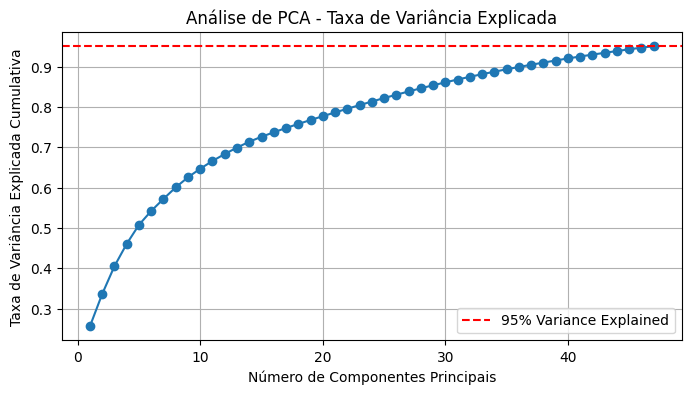

Número de componentes principais selecionados: 47


In [38]:
# Calcular a taxa de variância explicada cumulativa
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plotar a taxa de variância explicada
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Taxa de Variância Explicada Cumulativa')
plt.title('Análise de PCA - Taxa de Variância Explicada')
plt.grid(True)
plt.legend()
plt.show()

# Selecionar as componentes principais automaticamente com n_components=0.95
print(f"Número de componentes principais selecionados: {pca.n_components_}")

In [39]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(principalComponents, y_train)


In [40]:
del df_filtrado, data, train_identity, train_transaction,principalDF
gc.collect()

3735

In [41]:
%%time
# Define o número de folds para validação cruzada
n_splits = 5

# Inicializa o objeto StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 16.5 µs


In [42]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Definir os classificadores com seus hiperparametros
classifiers = [  
   
    {
        'name': 'KNN',
        'estimator': KNeighborsClassifier(),
        'parameters': {'n_neighbors': [3, 5, 7]}
    },
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(solver='liblinear'),
        'parameters': {'C': [1.0, 10.0, 100.0]}
    },
    {
        'name': 'Decision Tree',
        'estimator': DecisionTreeClassifier(),
        'parameters': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    },
    {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(),
        'parameters': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    },
    {
       'name': 'SVM',
       'estimator': SVC(),
       'parameters': {'C': [1.0, 10.0, 100.0], 'kernel': ['linear', 'poly', 'rbf']}
    }
]
    
# Realizar StratifiedKFold Cross Validation e imprimir resultados
skf = StratifiedKFold(n_splits=5)


CPU times: user 21.2 ms, sys: 26.1 ms, total: 47.3 ms
Wall time: 47 ms


Classificador: KNN
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Melhores hiperparâmetros: {'n_neighbors': 3}
Acurácia Média: 0.9383469244521997


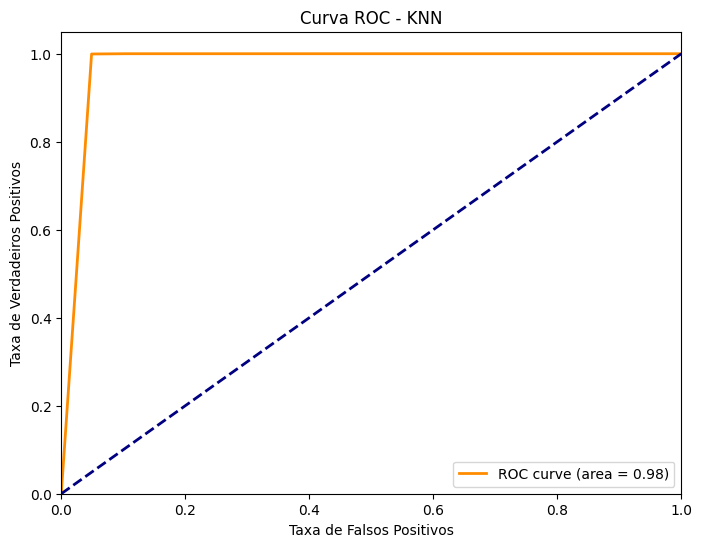

Matriz de Confusão:
[[32013  3832]
 [    0 35498]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     35845
           1       0.90      1.00      0.95     35498

    accuracy                           0.95     71343
   macro avg       0.95      0.95      0.95     71343
weighted avg       0.95      0.95      0.95     71343

Classificador: KNN
Melhores hiperparâmetros: {'n_neighbors': 3}
Acurácia Média: 0.9383469244521997
------------------------
Classificador: Logistic Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Melhores hiperparâmetros: {'C': 10.0}
Acurácia Média: 0.7284552351374032


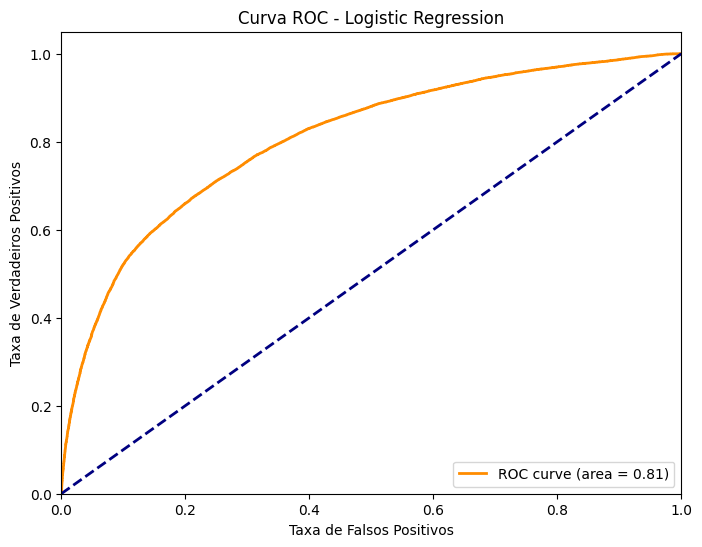

Matriz de Confusão:
[[27387  8458]
 [10790 24708]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74     35845
           1       0.74      0.70      0.72     35498

    accuracy                           0.73     71343
   macro avg       0.73      0.73      0.73     71343
weighted avg       0.73      0.73      0.73     71343

Classificador: Logistic Regression
Melhores hiperparâmetros: {'C': 10.0}
Acurácia Média: 0.7284552351374032
------------------------
Classificador: Decision Tree
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Melhores hiperparâmetros: {'min_samples_split': 5, 'max_depth': None, 'criterion': 'entropy'}
Acurácia Média: 0.9118796218650658


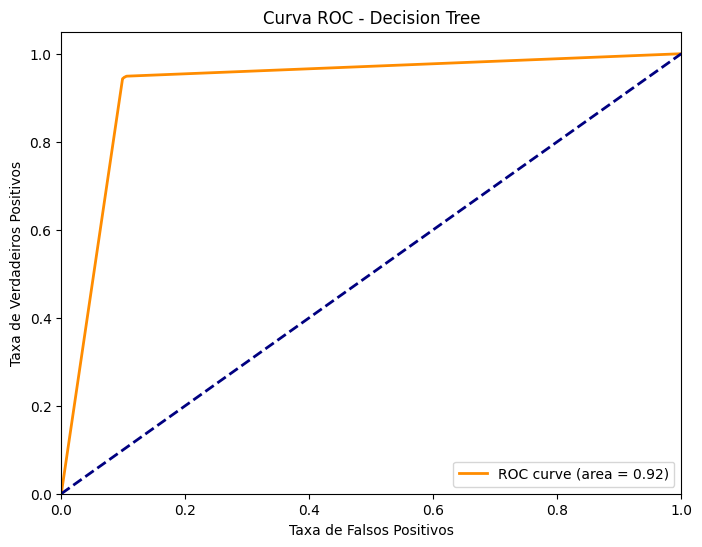

Matriz de Confusão:
[[32216  3629]
 [ 1913 33585]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     35845
           1       0.90      0.95      0.92     35498

    accuracy                           0.92     71343
   macro avg       0.92      0.92      0.92     71343
weighted avg       0.92      0.92      0.92     71343

Classificador: Decision Tree
Melhores hiperparâmetros: {'min_samples_split': 5, 'max_depth': None, 'criterion': 'entropy'}
Acurácia Média: 0.9118796218650658
------------------------
Classificador: Random Forest
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 4/5] END .....................n_neighbors=3;, score=0.939 total time=  33.5s
[CV 3/5] END .....................n_neighbors=5;, score=0.920 total time=  33.3s
[CV 2/5] END .....................n_neighbors=7;, score=0.912 total time=  30.4s
[CV 5/5] END .....................n_neighbors=7;, score=0.910 total time=  27.

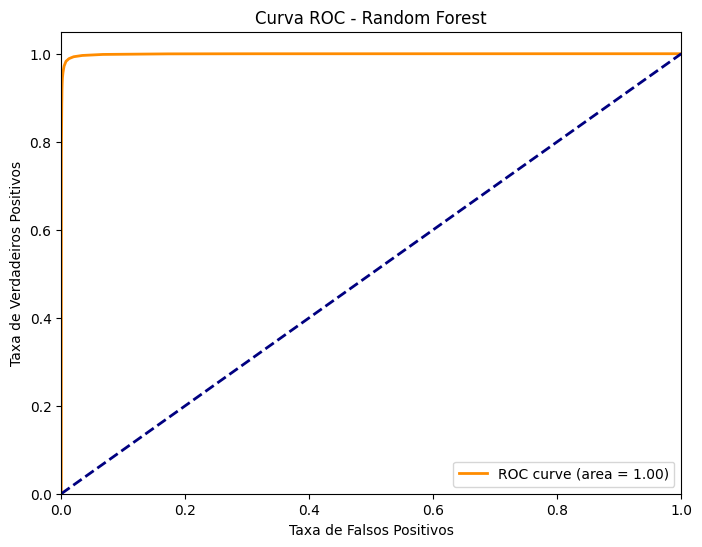

Matriz de Confusão:
[[35357   488]
 [  374 35124]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     35845
           1       0.99      0.99      0.99     35498

    accuracy                           0.99     71343
   macro avg       0.99      0.99      0.99     71343
weighted avg       0.99      0.99      0.99     71343

Classificador: Random Forest
Melhores hiperparâmetros: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None}
Acurácia Média: 0.984420278744253
------------------------
Classificador: SVM
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# Supondo que 'classifiers' seja uma lista de dicionários com informações dos classificadores
for clf_info in classifiers:
    clf_name = clf_info['name']
    clf = clf_info['estimator']
    param_dist = clf_info['parameters']

    print(f"Classificador: {clf_name}")

    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=3, cv=skf, scoring='accuracy', 
                                       verbose=3, n_jobs=4)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Melhores hiperparâmetros:", best_params)

    best_score = random_search.best_score_
    print("Acurácia Média:", best_score)

    # Treinar o modelo com os melhores parâmetros no conjunto de treinamento completo
    best_model = clf.set_params(**best_params)
    best_model.fit(X_train, y_train)

    # Prever as probabilidades de classe no conjunto de teste
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # Calcular a curva ROC e AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {clf_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Imprimir a matriz de confusão
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)
    
    # Adicionar a métrica de precisão, recall e F1-score
    classification_rep = classification_report(y_test, y_pred)
    print("Relatório de Classificação:\n", classification_rep)

    print(f"Classificador: {clf_name}")
    print("Melhores hiperparâmetros:", best_params)
    print("Acurácia Média:", best_score)
    print("------------------------")